In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 


# Constants (modify them depending on the directory where you have the data files stored)

PATH = "data/yXtrain.csv"
DELIMITER = ","

def get_data(path, delimiter):
    """
    Gets data from the file 'path' with delimeter 'delimiter' where y is a vector of length n and X is n x p matrix.
    """
    dataframe = pd.read_csv(path, delimiter=delimiter)
    array = dataframe.to_numpy()
    y = array[:, 1]
    X = array[:, 2:]
    return X, y

def get_train_data():
    """
    Gets training data.
    """
    return get_data(PATH, DELIMITER)

def train_val_split(X, y, val_start, val_end):
    """
    Splits data into training and validation datasets.
        Parameters:
        - X (np.array): Matrix of data, shape n x p.
        - y (np.array): Vector of targets, size n.
        - val_start (int): Start index for the validation dataset.
        - val_end (int): End index for the validation dataset.
        Returns:
        - X_train (np.array): Matrix of data, shape n_train x p.
        - y_train (np.array): Vector of targets, size n_train.
        - X_val (np.array): Matrix of data, shape n_val x p.
        - y_val (np.array): Vector of targets, size n_val.
    """
    X_val = X[val_start:val_end]
    y_val = y[val_start:val_end]
    X_train = np.concatenate((X[:val_start], X[val_end:]))
    y_train = np.concatenate((y[:val_start], y[val_end:]))
    return X_train, y_train, X_val, y_val

# soft-thresholding function
def soft_thresholding(x, lambda_):
    
    # Parameters
    # x (np.array): Vector.
    # lambda_ :  the regularization parameter

    # Returns
    # (np.array): filtered vector

    return np.sign(x) * np.maximum(np.abs(x) - lambda_, 0)

# FISTA function definition for Lasso
# Minimize 1/n ||y - beta_0 1 - X beta||_2^2 + lam ||beta||
def fista_lasso(X, y, lambda_, L, max_iter=1e5, tol=1e-8):

    # Parameters
    # X (np.array): Matrix of data, shape n x p.
    # y (np.array): Vector of targets, size n.
    # lambda_ :  the regularization parameter
    # L : the maximum of the eigenvalues of X
    # max_iter : maximum number of iterations
    # tol : tolerance of the error
    
    # Returns
    # beta (np.array): the solution of the minimisation problem
    
    X_transpose = np.transpose(X)
    Xi = np.concatenate((np.ones(len(y)).reshape(-1,1), X), axis = 1)
    Xi_transpose = np.transpose(Xi)
    n, p = Xi.shape
    
    # Additional space for intercept
    beta = np.zeros(p)
    
    # Fista variables
    z = np.zeros(p-1)
    t = 1
    gradient = np.zeros(p-1)

    # Loop variables
    continue_ = True
    current_iter = 1
    
    while continue_:
        
        beta_old = np.copy(beta)

        # Gradient step
        r=y-beta[0]
        gradient = - 2 * np.dot(X_transpose, (r - np.dot(X, beta[1:])))

        beta_temp = z - (1/L) * gradient

        # Proximal operator (soft-thresholding)
        beta[1:] = soft_thresholding(beta_temp, (n*lambda_) / L)

        # Update t and z
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        z = beta[1:] + ((t - 1) / t_new) * (beta[1:] - beta_old[1:])

        r=y-np.dot(X, beta[1:])
        beta[0] = np.mean(r)

        # Verification of convergence
        norm_squared_diff = np.sum((beta - beta_old)**2) / (1 + np.sum(beta**2))

        # Updates for next iteration
        t = t_new
        current_iter += 1
        
        # Decide whether to continue or not
        continue_ = (norm_squared_diff > tol) and (current_iter < max_iter)
    
    if current_iter == max_iter:
        print(f"WARNING: solution might be inaccurate, FISTA solver stopped after {current_iter} iterations.")

    return beta

def least_square(X, y):
    """
    Calculates least square solution for given data.
    """
    Xt_X = np.matmul(X.transpose(), X)
    Xt_X_inv = np.linalg.inv(Xt_X)
    return np.matmul(np.matmul(Xt_X_inv, X.transpose()), y)

def linear_model(X, beta):
    """
    Calculates linear model with y = beta_0 + X*beta.
    """
    return beta[0] + np.dot(X, beta[1:]) 

In [44]:
# Get data and its shape 
X, y = get_train_data()
n, p = np.shape(X)

# Shuffle the data by a random permutation

# Get max of eigenvalues of X_t*X for fista_lasso
L = np.max(np.linalg.eigvals(np.dot(X.transpose(), X)))

# Let us code 10 fold crossvalidation for CV to demonstrate overfitting in the future
def cross_validation_ls():
    global X
    global y
    loss_array = []
    for i in range(399, 2000, 400):
        X_train, y_train, X_val, y_val = train_val_split(X, y, i-399, i)
        beta = least_square(np.insert(X_train, 0, 1.0, axis = 1), y_train)
        y_predicted = linear_model(X_val, beta)
        loss_array.append(np.mean((y_val - y_predicted)**2))
    return np.mean(loss_array)

def cross_validation_lasso(lambda_):
    global X
    global y
    global L
    loss_array = []
    for i in range(399, 2000, 400):
        X_train, y_train, X_val, y_val = train_val_split(X, y, i-399, i)
        beta = fista_lasso(X_train, y_train, lambda_, L)
        y_predicted = linear_model(X_val, beta)
        loss_array.append(np.mean((y_val - y_predicted)**2))
    return np.mean(loss_array)        

In [45]:
"""
Now we will demonstrate overfitting on example of the least square.
For this we will calculate least square solution using training set, apply this model to validation set and compear the outcomes.
"""
# Get least square solution and calculate SRSS
beta = least_square(np.insert(X, 0, 1.0, axis = 1), y)
y_predicted = linear_model(X, beta)
diff_train = y - y_predicted

91.39929194992581 96.99201645450933


In [46]:
"""
We see that least square method fails to give an accurate prediction on the validation set which is a sighn of overfitting.
Now let us implement SURE method to regularise and avoid overfitting.
"""
sigma_ls = np.sum(diff_train ** 2) / (n - p)
def SURE(lambda_):
    global X
    global y
    global L
    global sigma_ls
    beta = fista_lasso(X, y, lambda_, L)
    rss = np.sum((y - linear_model(X, beta)) ** 2)
    p_l = 0
    for a in beta:
        if abs(a) > 1e-12:
            p_l += 1
    return rss + 2*sigma_ls*p_l - n*sigma_ls, cross_validation_lasso(lambda_) 



In [47]:
Lambda_grid = np.logspace(-3, 0.5, 150)
Y_SURE = np.array([SURE(lambda_)[0] for lambda_ in Lambda_grid])
Y_MSE = np.array([SURE(lambda_)[1] for lambda_ in Lambda_grid])

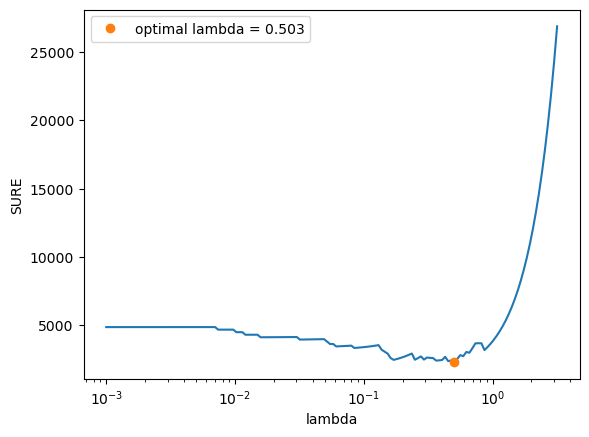

In [48]:
import matplotlib.pyplot as plt
i_sure = np.argmin(Y_SURE)
i_mse = np.argmin(Y_MSE)
plt.plot(Lambda_grid, Y_SURE)
plt.xlabel("lambda")
plt.ylabel("SURE")
plt.plot(Lambda_grid[i_sure], Y_SURE[i_sure] , 'o', label = f"optimal lambda = {round(Lambda_grid[i_sure], 3)}")
plt.legend()
plt.xscale("log")
plt.show()

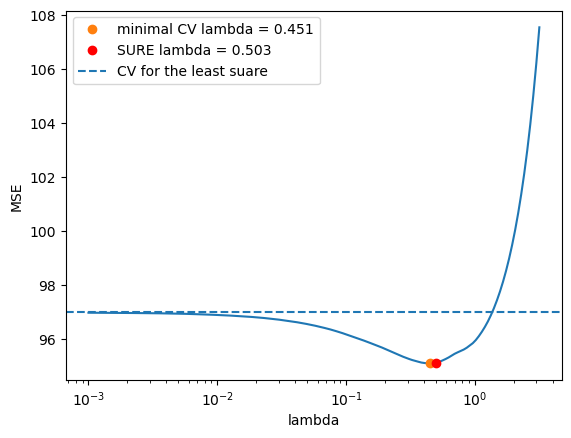

In [50]:
plt.plot(Lambda_grid, Y_MSE)
plt.plot(Lambda_grid[i_mse], Y_MSE[i_mse], 'o', label = f"minimal CV lambda = {round(Lambda_grid[i_mse], 3)}")
plt.plot(Lambda_grid[i_sure], Y_MSE[i_sure], 'o', label = f"SURE lambda = {round(Lambda_grid[i_sure], 3)}", color = 'red')
plt.axhline(y = 96.99201645450933, label = "CV for the least suare", ls = '--' )
plt.xlabel("lambda")
plt.ylabel("MSE")
plt.legend()
plt.xscale("log")
plt.show()

In [8]:
true_beta = fista_lasso(X, y, Lambda_grid[i_sure], L)

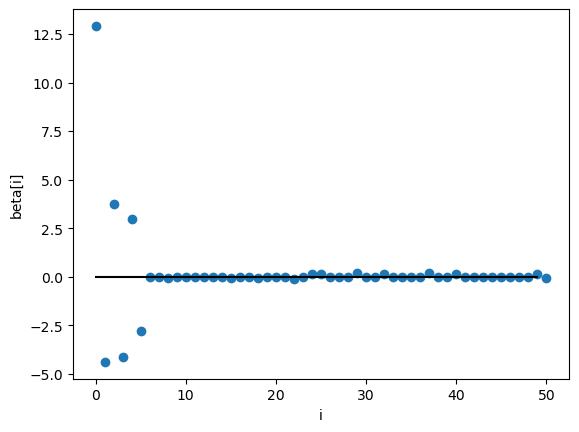

18


In [41]:
plt.scatter([i for i in range(p+1)], true_beta)
plt.plot(np.zeros(50), color = 'black')
plt.xlabel('i')
plt.ylabel("beta[i]")
plt.show()
print(np.count_nonzero(true_beta))

In [11]:
relevant_beta = np.concatenate((true_beta[0:6], np.zeros(45)))

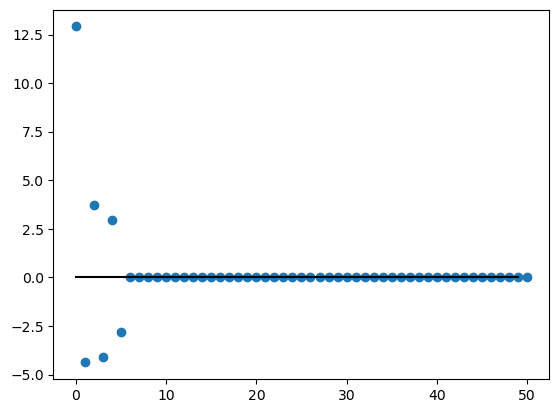

6


In [14]:
plt.scatter([i for i in range(p+1)], relevant_beta)
plt.plot(np.zeros(50), color = 'black')
plt.show()

print(np.count_nonzero(relevant_beta))